<center>
    <h1>Fruit Inspection</h1>
    <h2>Image Processing and Computer Vision</h2>
    <h3>Facundo Nicolas Maidana and Riccardo Spolaor</h3>
    <h4>facundo.maidana@studio.unibo.it; riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This notebook presents the development of a system aimed at locating defects and imperfection in fruits. Each fruit is acquired through a NIR *(Near Infra-Red)* and color camera that present little parallax effect among each other.

The first task considers the images in the folder `images/first task/`, that present apples with external defects which are clearly visible.

| NIR example                   | Colour example                |
|:-----------------------------:|:-----------------------------:|
| ![](attachment:C0_000001.png) | ![](attachment:C1_000001.png) |

In order to localize these defects two steps have to be carried out:
- Each fruit should be outlined by means of a binary mask that separates the foreground (the fruit) from the background. This step is performed through a tresholding technique;
- A search to identify the defects on the fruit must be carried out on the outlined portion of the image.

*Note: given the fact that NIR and color images have little parallax, a mask can be computed on one and applied to the other.*

#### Procedure
Although this is an academic project, the working pipeline has been developed considering an industrial setting where the inspection of the fruits has to be carried out by an *online* system. A set of methods have been tested in terms of quality, speed and robustness.

# 00 Prerequisites
The libraries necessary for the task are imported.

In [49]:
%matplotlib inline

import cv2 as cv
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.spatial.distance import cdist
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
from time import time

# Utils libraries
from utils import *

The cell below illustrates the version of `OpenCV` used for the task.

In [2]:
print(f'Using OpenCV version: {cv.__version__}.')

Using OpenCV version: 4.6.0.


The random seed is set for both the `numpy` and `OpenCV` libraries in order to guarantee reproducibility of results.

In [3]:
SEED = 42

cv.setRNGSeed(SEED)
np.random.seed(SEED)

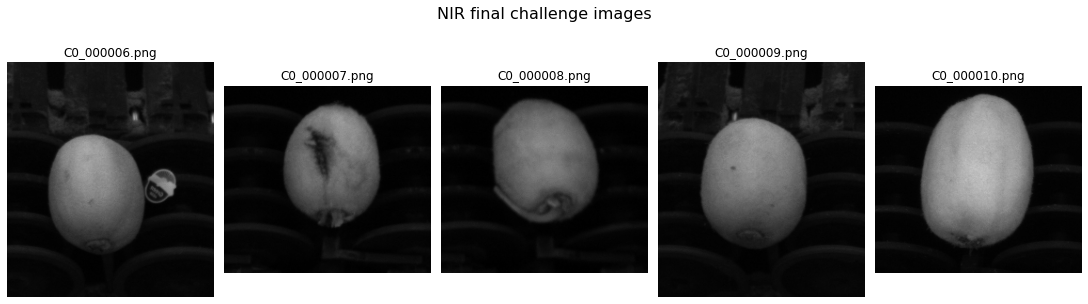

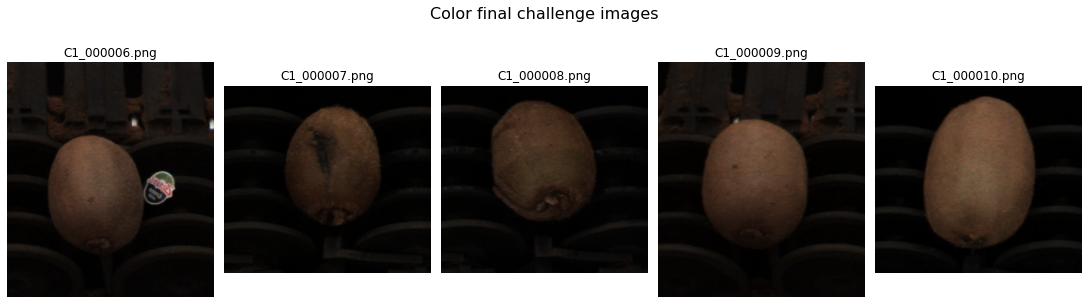

In [4]:
# Create two arrays containing the names of the NIR and color images respectively
nir_names, colour_names = [[f'C{j}_{str(i).zfill(6)}.png' for i in range(6,11)] for j in [0,1]]

# Directory where the images are saved
DIR = 'images/final challenge/'

# Import NIR and color images
nir_imgs = [cv.imread(f'{DIR}{img}', cv.IMREAD_GRAYSCALE) for img in nir_names]
colour_imgs = [cv.imread(f'{DIR}{img}') for img in colour_names]

# Plot the NIR and color images
plot_image_grid(nir_imgs, nir_names, 'NIR final challenge images')
plot_image_grid(colour_imgs, colour_names, 'Color final challenge images')

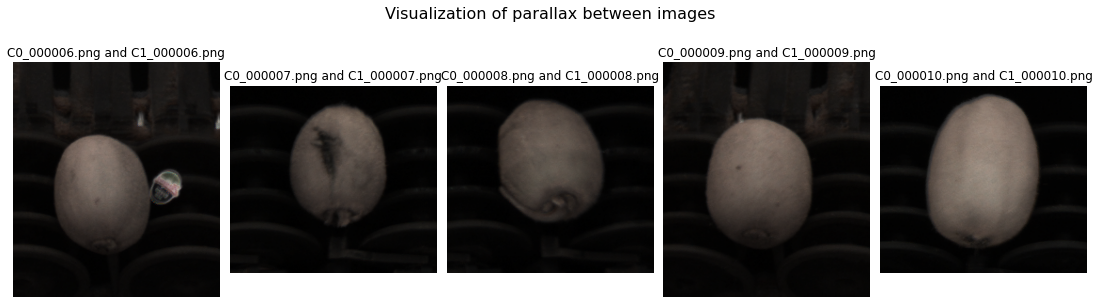

In [5]:
parallaxes = [cv.addWeighted(cv.cvtColor(n, cv.COLOR_GRAY2BGR), 0.5, c, 0.5, 0) 
              for n, c in zip(nir_imgs, colour_imgs)]

plot_image_grid(parallaxes, [f'{n} and {c}' for n, c in zip(nir_names, colour_names)], 
                'Visualization of parallax between images')

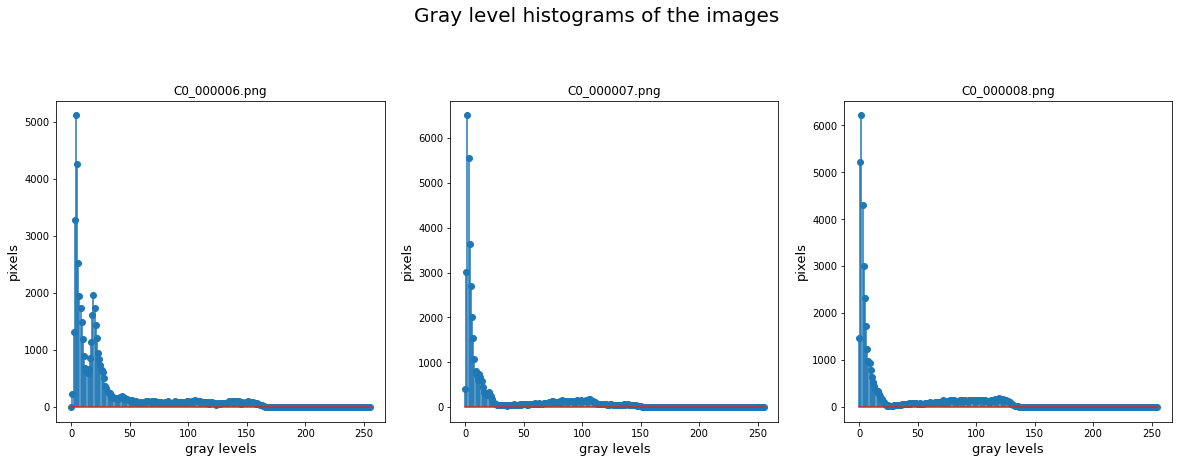

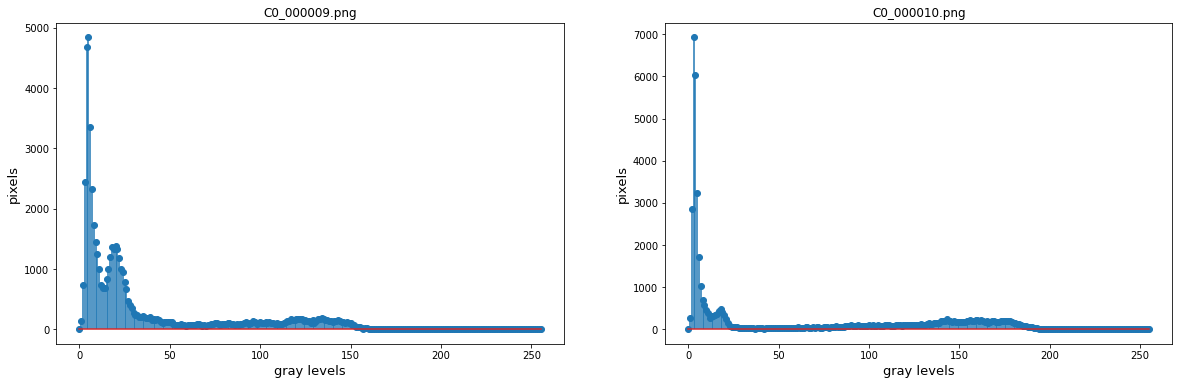

In [6]:
plot_histogram_grid(nir_imgs[:3], nir_names[:3], 'Gray level histograms of the images')
plot_histogram_grid(nir_imgs[3:], nir_names[3:], '')

In [7]:
'''equalized_nir_imgs = [cv.equalizeHist(img) for img in nir_imgs]
plot_image_grid(equalized_nir_imgs, nir_names, 'Equalized NIR images')'''

"equalized_nir_imgs = [cv.equalizeHist(img) for img in nir_imgs]\nplot_image_grid(equalized_nir_imgs, nir_names, 'Equalized NIR images')"

Images are equalized because compared to the grayscale images of previous tasks, the range of poorly used histogram intensities is larger ($[150, 255]$)

In [8]:
'''filtered_images = [cv2.medianBlur(img,7) for img in equalized_nir_imgs]
plot_image_grid(filtered_images, nir_names, 'Equalized NIR images')'''

"filtered_images = [cv2.medianBlur(img,7) for img in equalized_nir_imgs]\nplot_image_grid(filtered_images, nir_names, 'Equalized NIR images')"

In [9]:
filtered_images = [cv2.medianBlur(img,7) for img in nir_imgs]

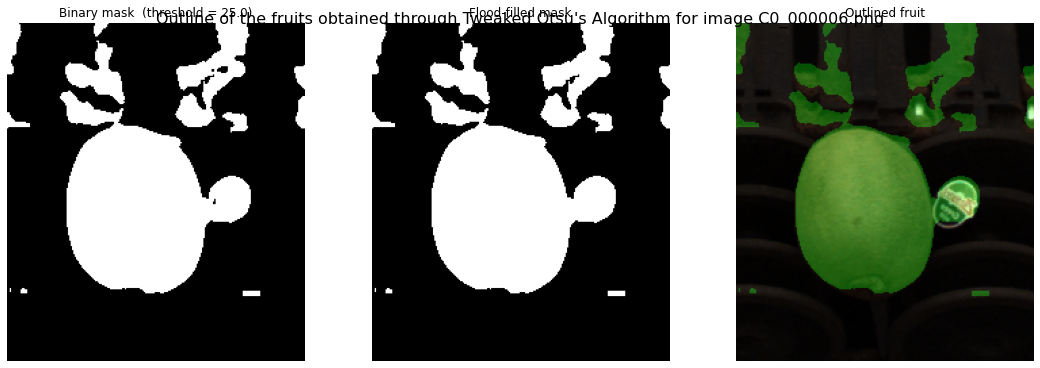

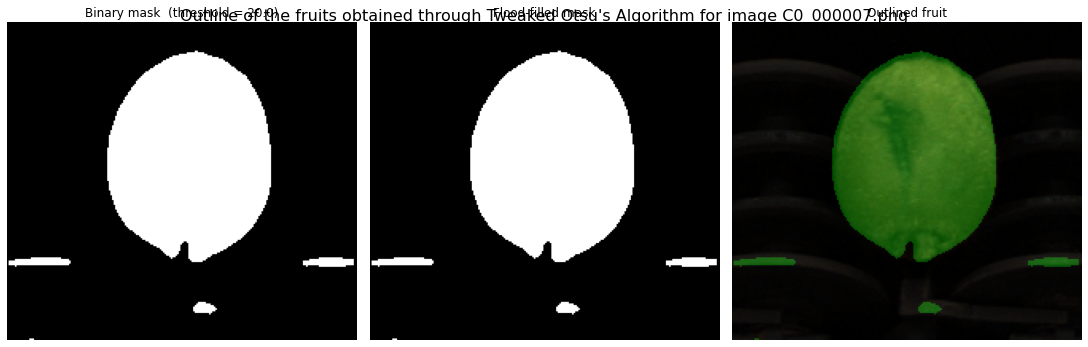

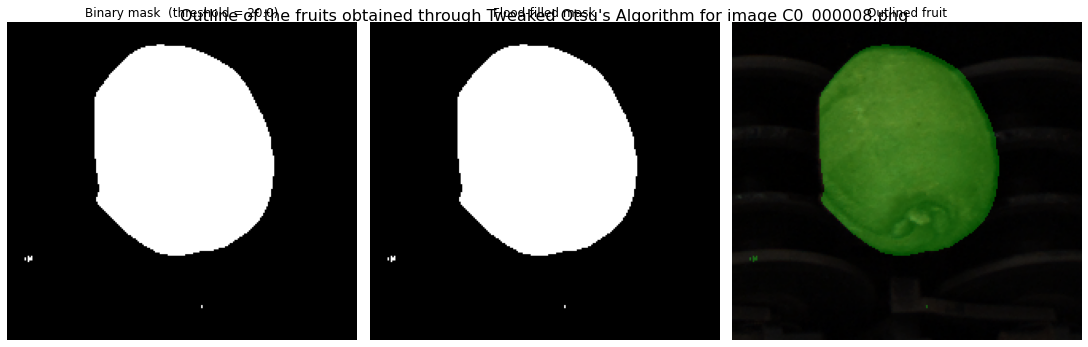

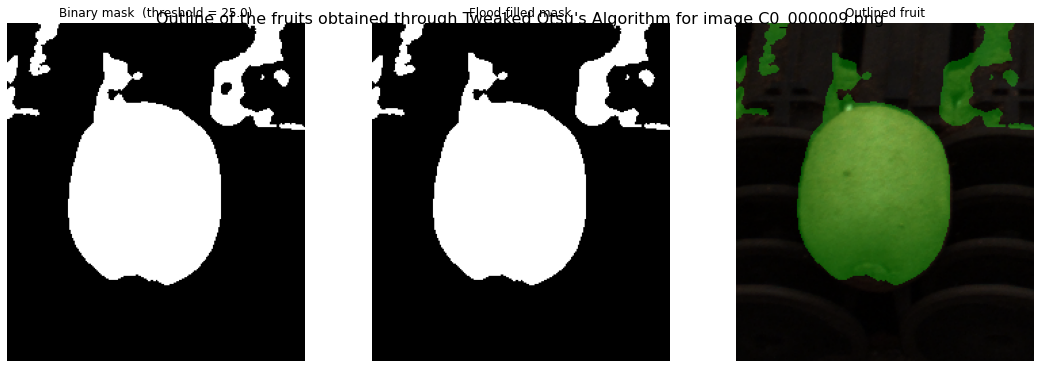

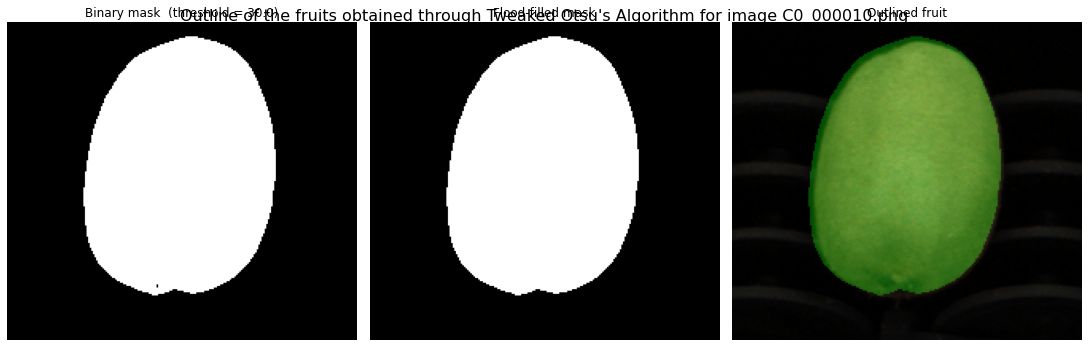

In [10]:
TWEAK_FACTOR = .4

plot_masking_process(filtered_images, colour_imgs, nir_names, ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

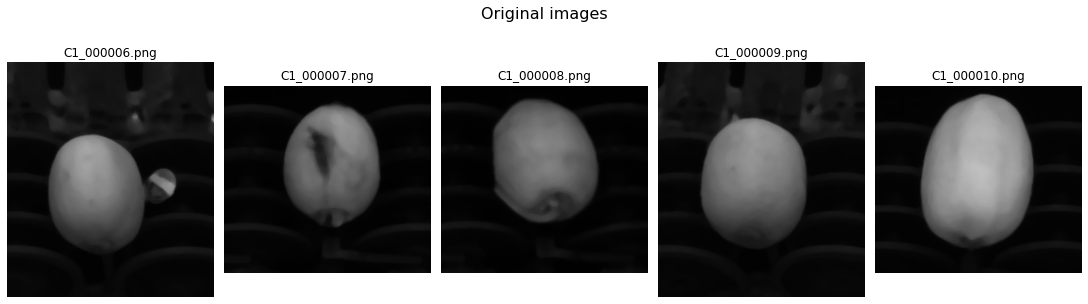

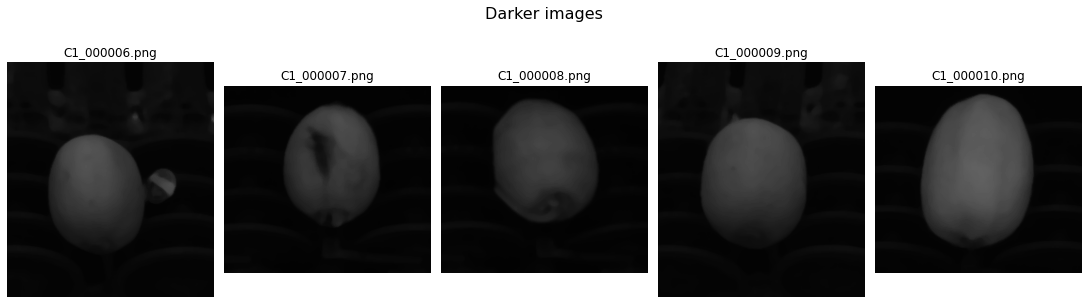

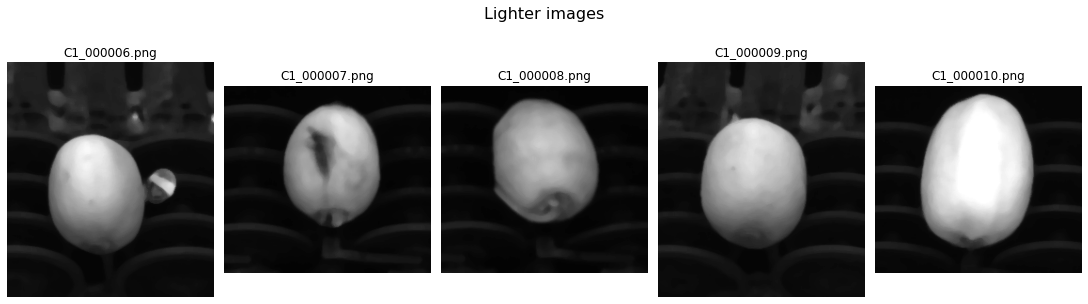

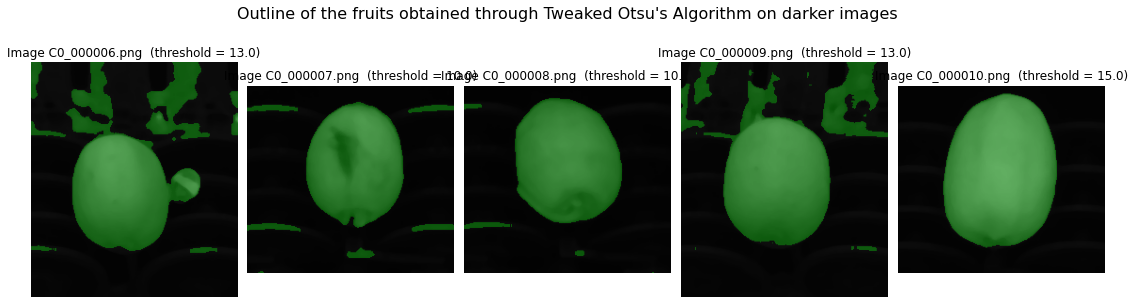

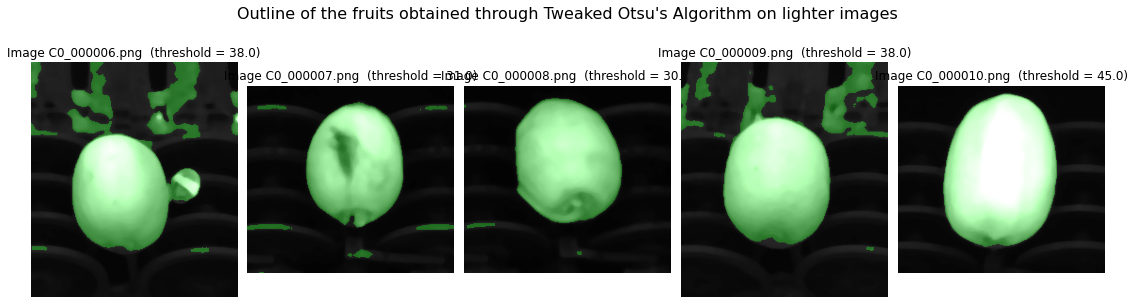

In [11]:
filtered_darker_images = [change_contrast_grayscale(img, .5) for img in filtered_images]
filtered_lighter_images = [change_contrast_grayscale(img) for img in filtered_images]

plot_image_grid(filtered_images, colour_names, 'Original images')
plot_image_grid(filtered_darker_images, colour_names, 'Darker images')
plot_image_grid(filtered_lighter_images, colour_names, 'Lighter images')
plot_thresholding_on_light_and_dark_images(filtered_darker_images, filtered_lighter_images, nir_names, 
                                           ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

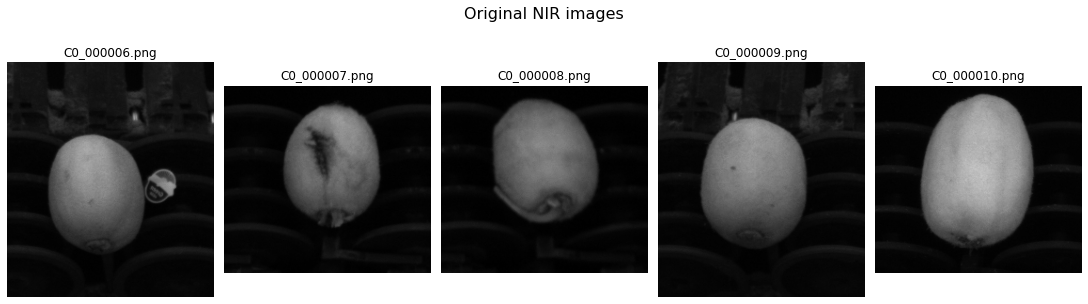

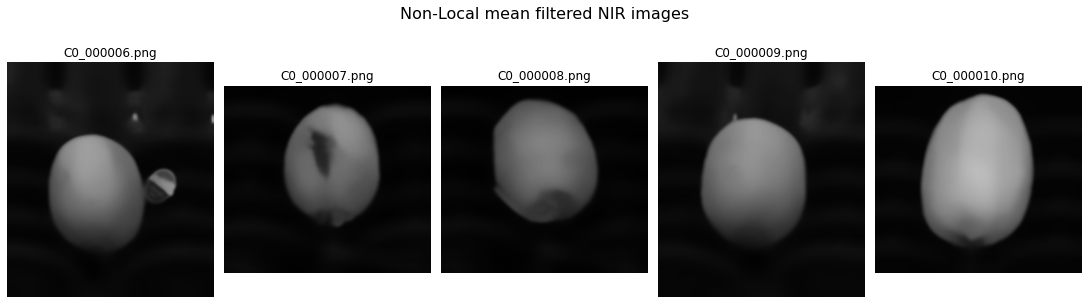

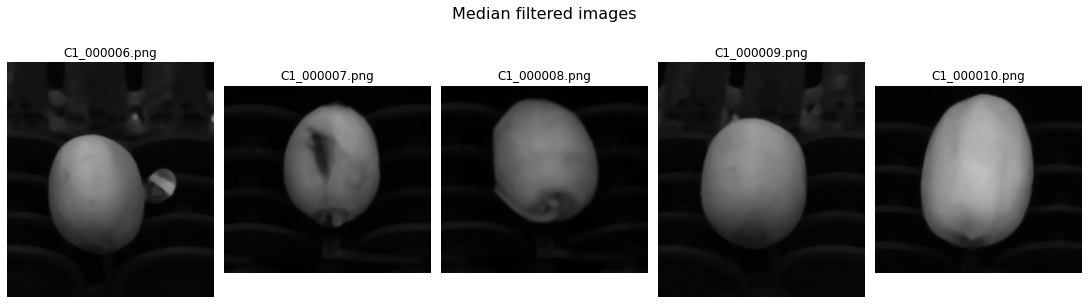

In [12]:
nl_filtered_imgs = [cv.fastNlMeansDenoising(img, h=25) for img in nir_imgs]
plot_image_grid(nir_imgs, nir_names, 'Original NIR images')
plot_image_grid(nl_filtered_imgs, nir_names, 'Non-Local mean filtered NIR images')
plot_image_grid(filtered_images, colour_names, 'Median filtered images')

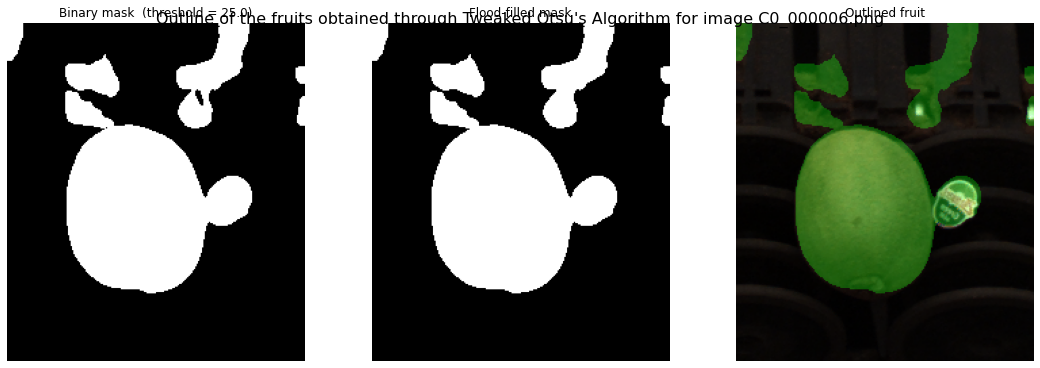

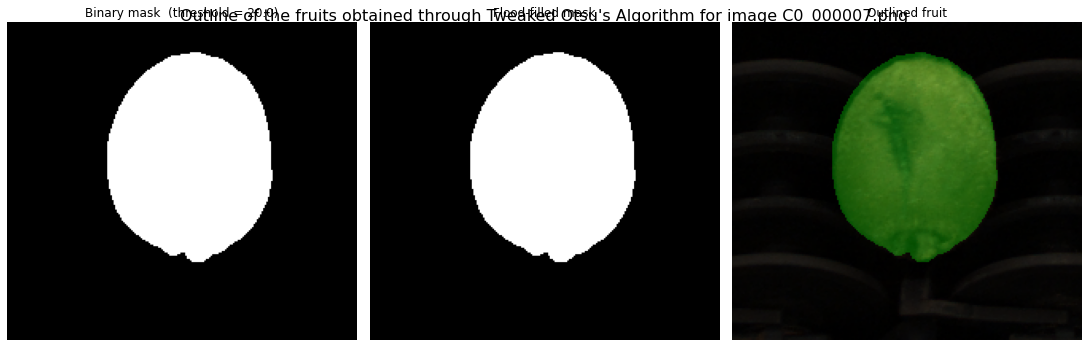

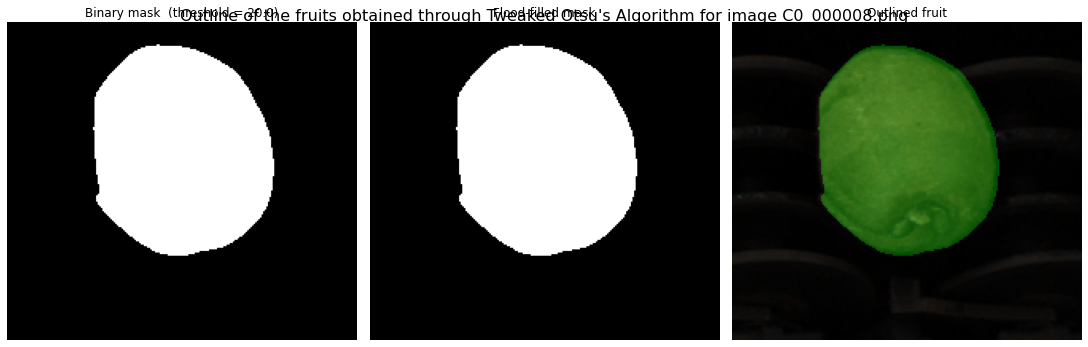

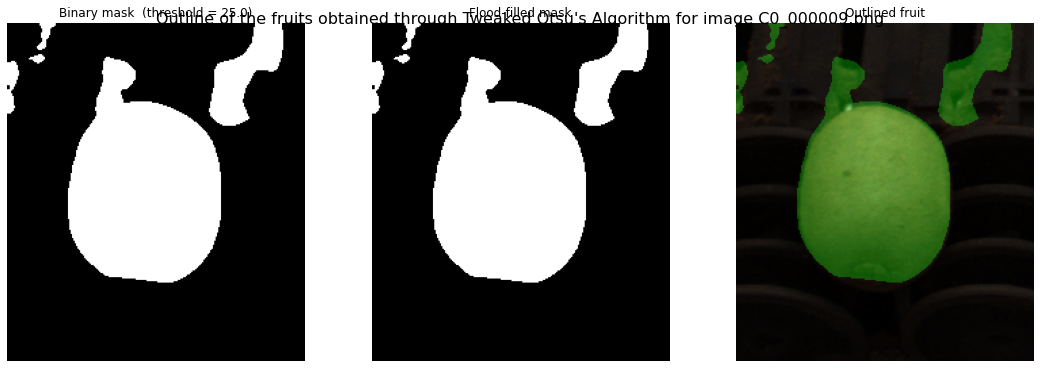

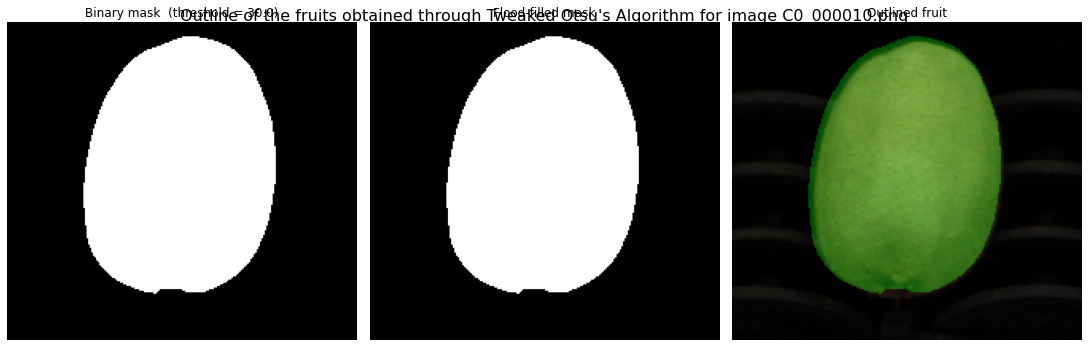

In [13]:
TWEAK_FACTOR = .4 #.5

plot_masking_process(nl_filtered_imgs, colour_imgs, nir_names, ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

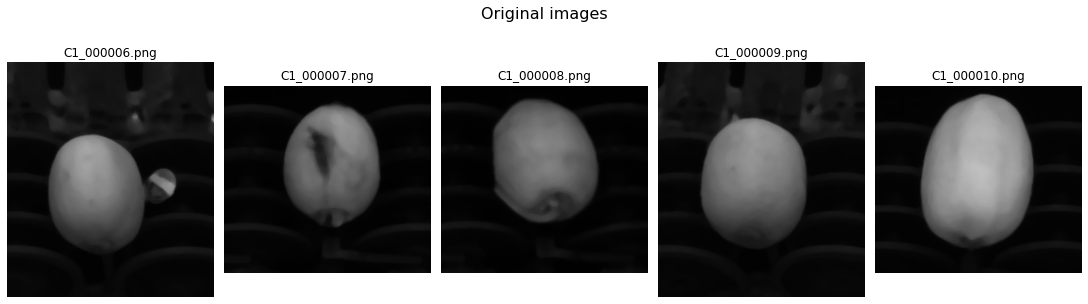

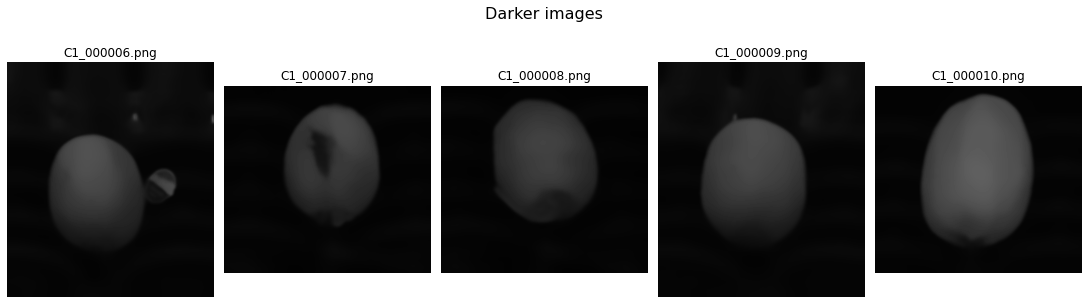

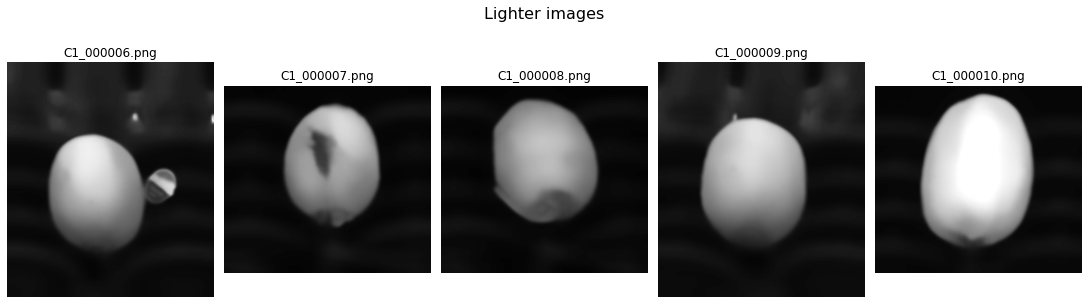

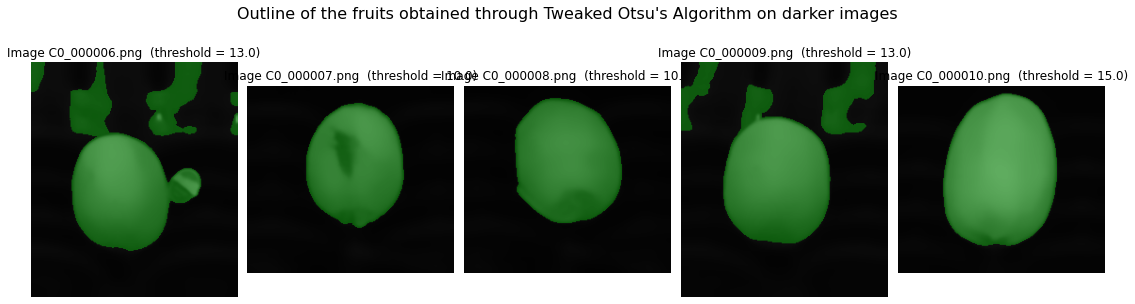

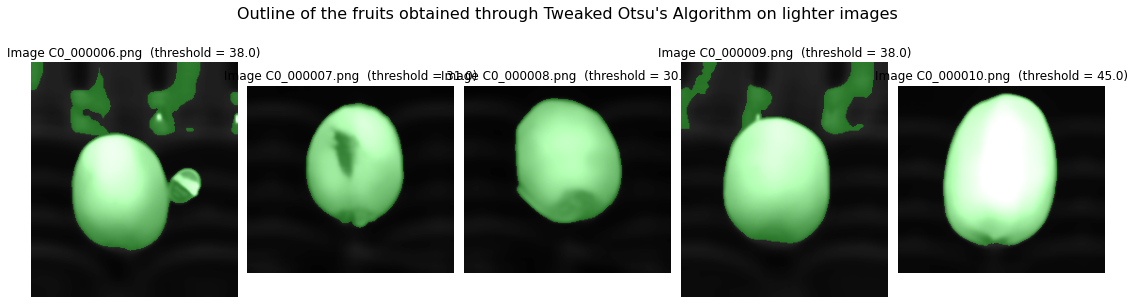

In [14]:
filtered_darker_images = [change_contrast_grayscale(img, .5) for img in nl_filtered_imgs]
filtered_lighter_images = [change_contrast_grayscale(img) for img in nl_filtered_imgs]

plot_image_grid(filtered_images, colour_names, 'Original images')
plot_image_grid(filtered_darker_images, colour_names, 'Darker images')
plot_image_grid(filtered_lighter_images, colour_names, 'Lighter images')
plot_thresholding_on_light_and_dark_images(filtered_darker_images, filtered_lighter_images, nir_names, 
                                           ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

In [15]:
'''s = time()
for img in nir_imgs * 100:
    cv.medianBlur(img,7)
median_time = time() - s

s = time()
for img in nir_imgs * 100:
    cv.fastNlMeansDenoising(img, h=25)
nl_denoising_time = time() - s''';

In [16]:
'''print(f'Time for preprocessing {100 * len(colour_imgs)} images with a median filter: {median_time:.6f}')
print(f'Mean time for preprocessing an image with a median filter: {(median_time / (100 * len(colour_imgs))):.6f}')
print()

print(f'Time for preprocessing {100 * len(colour_imgs)} images with a non-local mean filter: {nl_denoising_time:.6f}')
print(f'Mean time for preprocessing an image with a non-local mean filter: {(nl_denoising_time / (100 * len(colour_imgs))):.6f}')''';

In [17]:
#filtered_images

In [18]:
masks = [get_fruit_mask(img, ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR) for img in filtered_images]

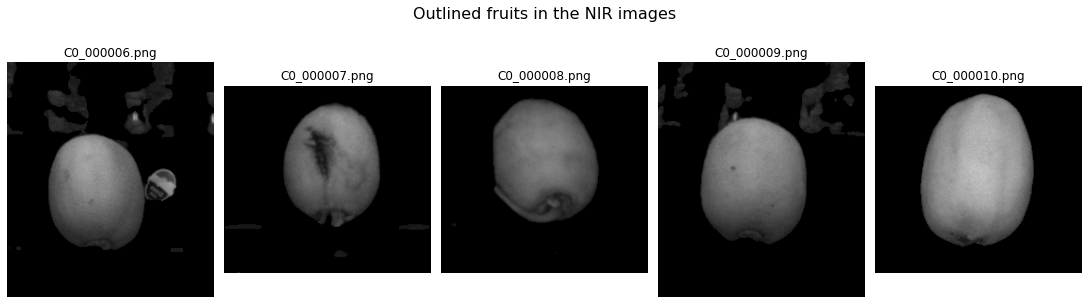

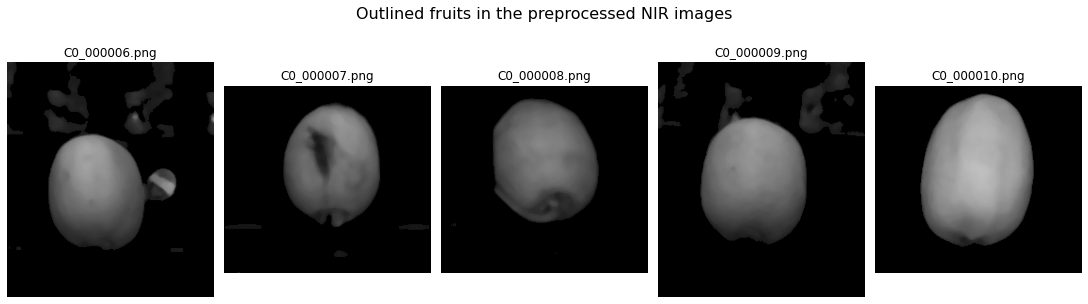

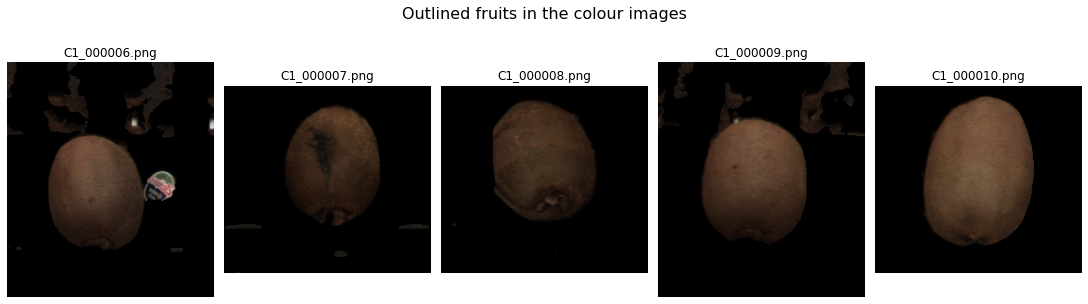

In [19]:
masked_nir_imgs = [nir_imgs[i] & masks[i] for i in range(len(masks))]
masked_filtered_imgs = [filtered_images[i] & masks[i] for i in range(len(masks))]
masked_colour_imgs = [colour_imgs[i] &  cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]

plot_image_grid(masked_nir_imgs, nir_names, 'Outlined fruits in the NIR images')
plot_image_grid(masked_filtered_imgs, nir_names, 'Outlined fruits in the preprocessed NIR images')
plot_image_grid(masked_colour_imgs, colour_names, 'Outlined fruits in the colour images')

In [63]:
s = time()
for i in range(100):
    se1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30,10))
    masks1 = [cv2.morphologyEx(m, cv2.MORPH_OPEN, se1) for m in masks]
    masked_nir_imgs1 = [nir_imgs[i] & masks1[i] for i in range(len(masks))]
total_time = time() - s

print(f'Total time taken: {total_time}')
print(f'Mean time per img: {total_time / (len(nir_imgs) *100)}')
#masks = [cv2.morphologyEx(m, cv2.MORPH_CLOSE, se2) for m in masks]

Total time taken: 0.9829235076904297
Mean time per img: 0.0019658470153808595


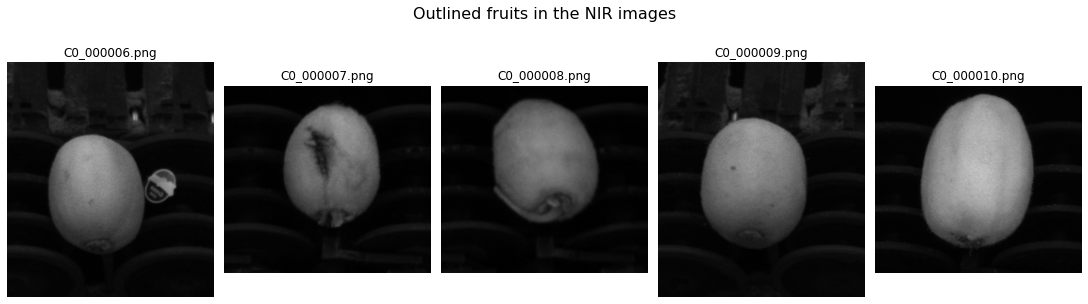

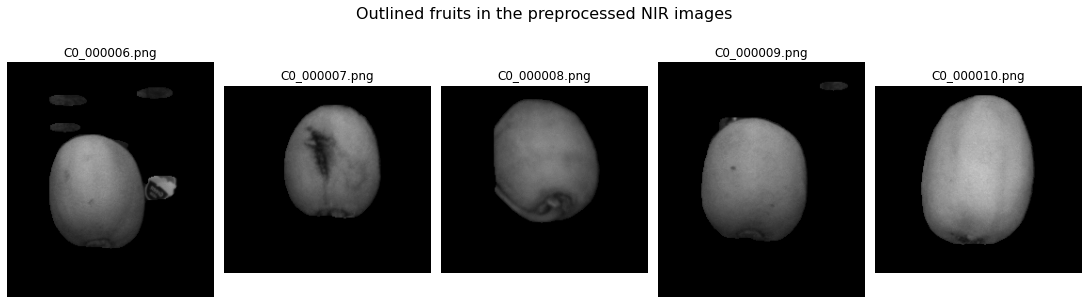

In [64]:
se1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30,10))
masks_open = [cv2.morphologyEx(m, cv2.MORPH_OPEN, se1) for m in masks]
masked_nir_imgs = [nir_imgs[i] & masks_open[i] for i in range(len(masks_open))]
plot_image_grid(nir_imgs, nir_names, 'Outlined fruits in the NIR images')
plot_image_grid(masked_nir_imgs, nir_names, 'Outlined fruits in the preprocessed NIR images')

In [ ]:
erosion_dst = cv.erode(src, element)
erosion_dst = cv.dilate(src, element)

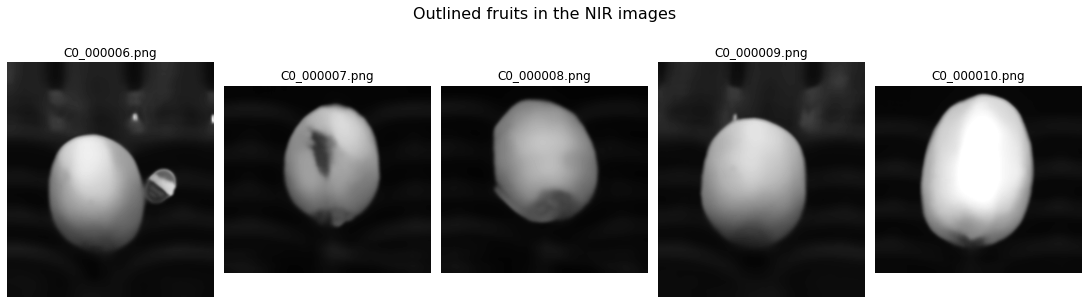

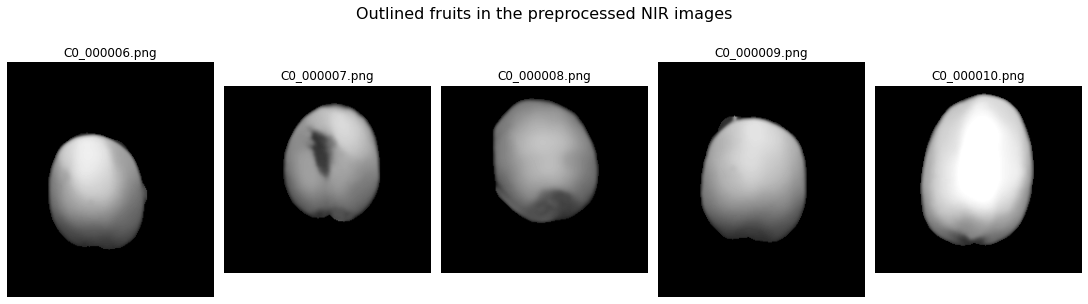

In [38]:
masks_open = [cv2.morphologyEx(m, cv2.MORPH_OPEN, se1) for m in masks]
masked_nir_imgs = [filtered_lighter_images[i] & masks_open[i] for i in range(len(masks_open))]
plot_image_grid(filtered_lighter_images, nir_names, 'Outlined fruits in the NIR images')
plot_image_grid(masked_nir_imgs, nir_names, 'Outlined fruits in the preprocessed NIR images')

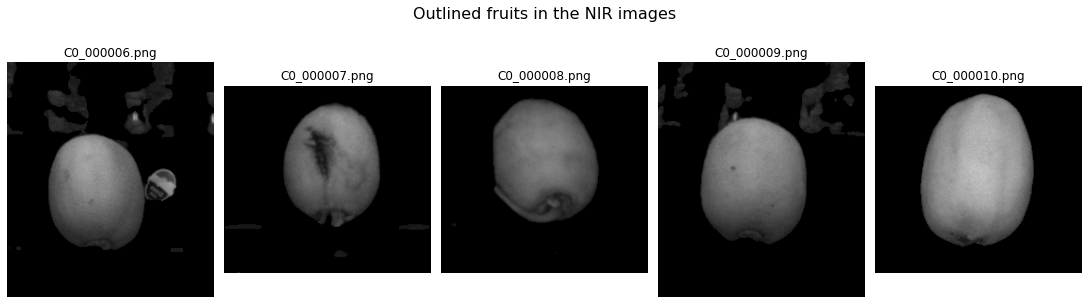

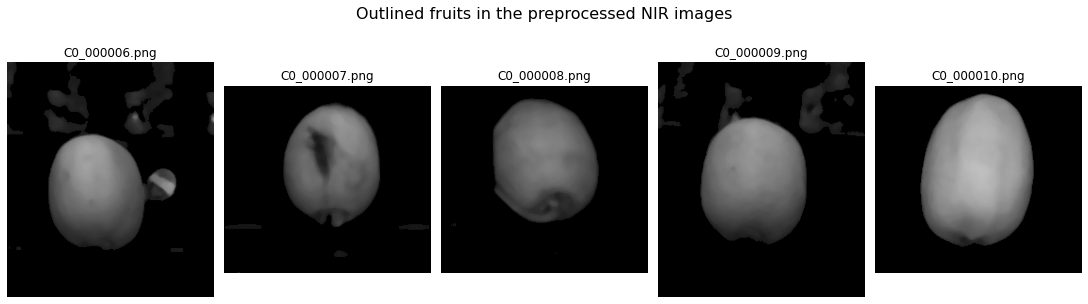

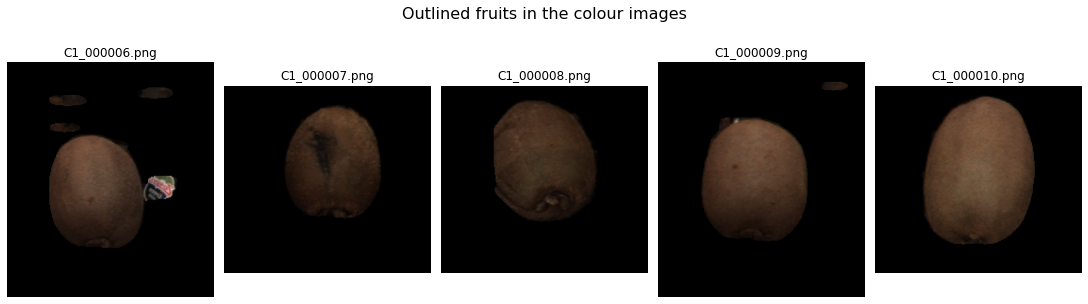

In [67]:
masked_nir_imgs = [nir_imgs[i] & masks[i] for i in range(len(masks))]
masked_filtered_imgs = [filtered_images[i] & masks[i] for i in range(len(masks))]
masked_colour_imgs = [colour_imgs[i] &  cv2.cvtColor(masks_open[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks_open))]

plot_image_grid(masked_nir_imgs, nir_names, 'Outlined fruits in the NIR images')
plot_image_grid(masked_filtered_imgs, nir_names, 'Outlined fruits in the preprocessed NIR images')
plot_image_grid(masked_colour_imgs, colour_names, 'Outlined fruits in the colour images')

In [68]:
def get_samples(roi, num_samples, patch_size):
    # Get all patches of size (`patch_size`, `patch_size`) from the image
    patches = list(extract_patches_2d(roi, (patch_size, patch_size), random_state=SEED))
    # Extract just the patches of the ROI (namely the ones where non 0 intensity pixels are present)
    roi_patches = [p for p in patches if np.all(p)]
    # Get index of `num_samples` randomly chosen samples
    samples_idx = np.random.choice(np.arange(len(roi_patches)), num_samples, replace=False)
    # Get samples based on the obtained random indices
    return [roi_patches[i] for i in samples_idx]

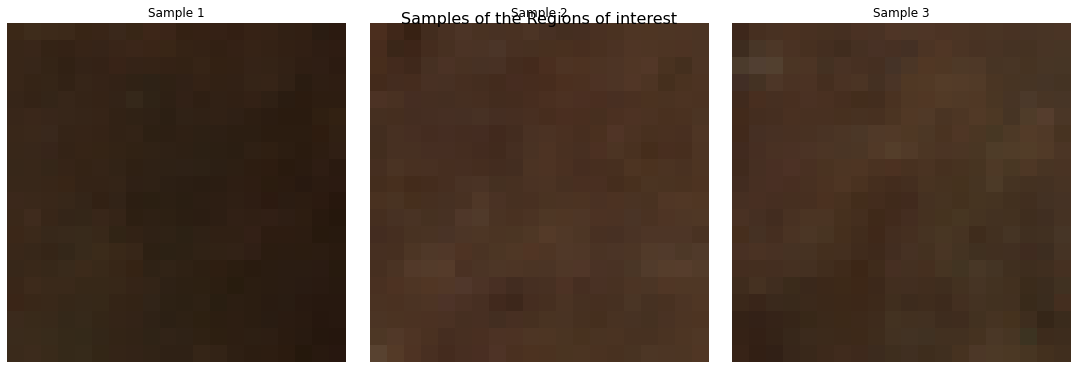

In [69]:
NUM_PATCHES = 200
PATCH_SIZE = 20

samples = get_samples(masked_colour_imgs[2], NUM_PATCHES, PATCH_SIZE)
samples += get_samples(masked_colour_imgs[4], NUM_PATCHES, PATCH_SIZE)

plot_image_grid([samples[0], samples[PATCH_SIZE], samples[PATCH_SIZE*2]], 
                [f'Sample {i}' for i in range(1,4)],
                'Samples of the Regions of interest')

In [70]:
def get_mean_and_inverse_covariance_matrix(samples, colour_space: ColourSpace, channels=[0,1,2]):
    colour_space_fun = colour_space.bgr_to_color_space
    # Get the number of channels
    channel_num = len(channels)

    # Set an array of 0s of the shape of the covariance matrix
    covariance_tot = np.zeros((channel_num, channel_num), dtype='float32')
    # Set an array of 0s of the shape of a mean vector of the color of the samples
    mean_tot = np.zeros((channel_num,), dtype='float32')

    for s in samples:
        s_colour_space = colour_space_fun(s)
        # Turn the sample patch in the selected colour space
        s_colour_space = colour_space_fun(s)[:,:,channels]
        # Reshape the sample patch
        s_colour_space = s_colour_space.reshape(-1, channel_num)
        # Obtain the covariance matrix and the mean for the patch
        cov, mean = cv2.calcCovarMatrix(s_colour_space, None, cv2.COVAR_NORMAL + cv2.COVAR_ROWS + cv2.COVAR_SCALE)
        # Add the obtained mean and the covariance to the ones of the previous patches 
        covariance_tot = np.add(covariance_tot, cov)
        mean_tot = np.add(mean_tot, mean)

    # Divide the sum of means by the number of samples
    mean = mean_tot / len(samples)
    # Divide the sum of covariances by the number of samples
    covariance = covariance_tot / len(samples)

    return mean, np.linalg.inv(covariance)

In [71]:
def get_mahalanobis_distance_img(img, mean, inverse_covariance_matrix, threshold, channels = [0,1,2]):
    # Get the number of channels of the image
    channel_num = len(channels)
    # Turn the mage in the selected colour space and get the requested channels
    img = img[:, :, channels]

    # Flatten the image and change the type to `float64`
    img_flattened = img.reshape(-1, channel_num)
    img_flattened = img_flattened.astype(np.float64)
    
    img_distances = cdist(img_flattened, mean, metric='mahalanobis', VI=inverse_covariance_matrix)
    
    img_distances = img_distances.reshape(img.shape[0], img.shape[1]);

    mask = np.copy(img_distances).astype(np.uint8)
    
    mask[img_distances >= threshold] = 0
    mask[img_distances < threshold] = 255

    return mask

In [72]:
def plot_mahalanobis_results(preprocessed_image, display_image, mean, inverse_covariance_matrix, thresholds, title, 
                             channels=[0,1,2]):
    highlighted_rois = []

    for threshold in thresholds:
        mask = get_mahalanobis_distance_img(preprocessed_image, mean, inverse_covariance_matrix, threshold, channels)
        highlighted_rois.append(get_highlighted_roi_by_mask(display_image, mask))

    plot_image_grid(highlighted_rois, [f'Detected pixels for threshold {t}' for t in thresholds], title)

In [73]:
lab_colour_space = ColourSpace('LAB')

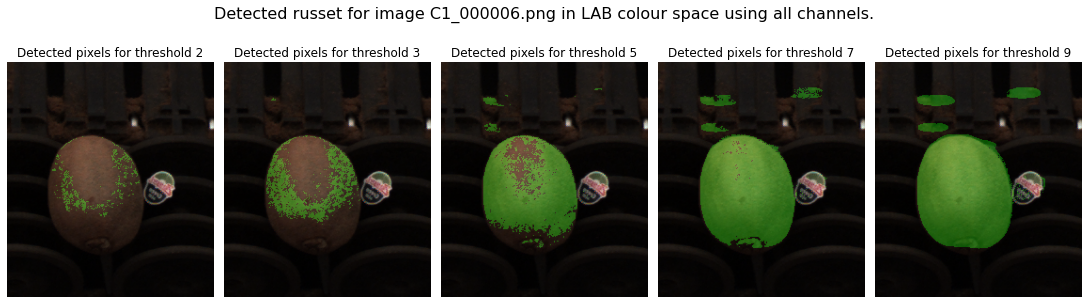

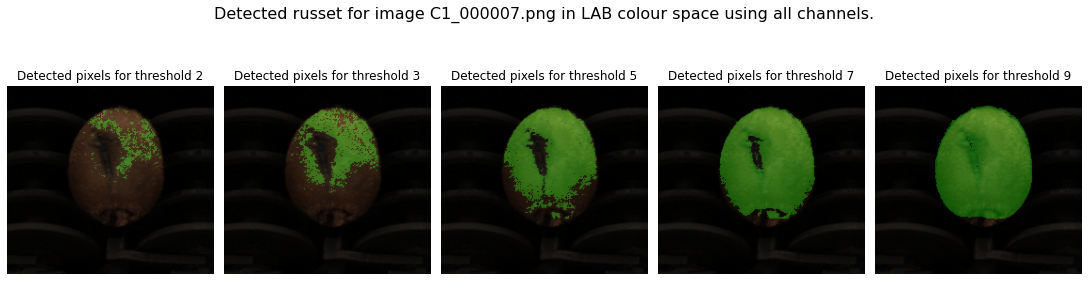

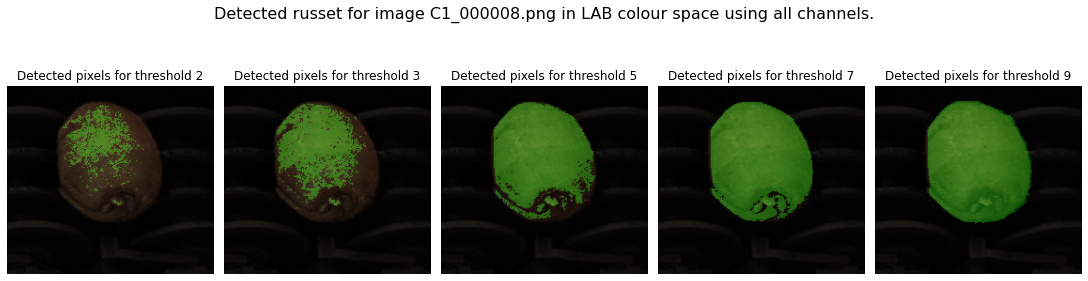

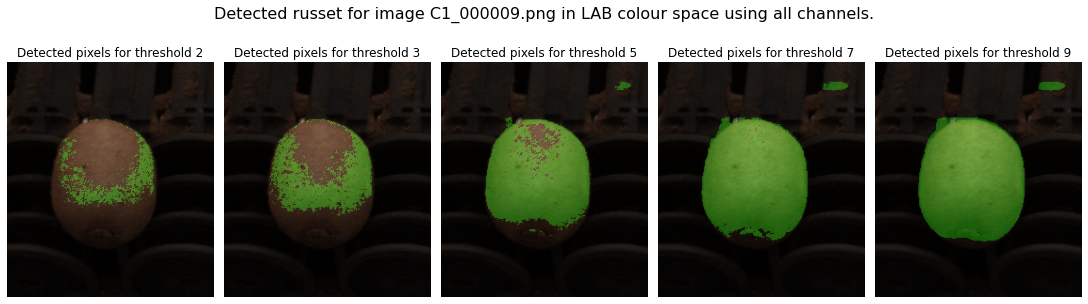

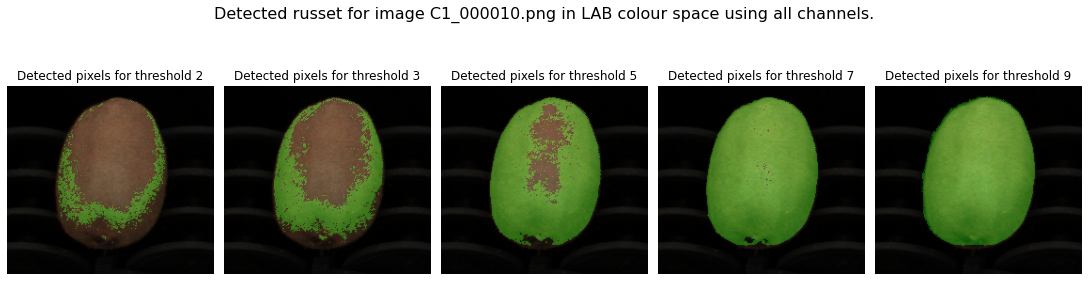

In [79]:
thresholds = [2, 3, 5, 7, 9]
mean, inv_cov = get_mean_and_inverse_covariance_matrix(samples, lab_colour_space)
for idx, img in enumerate(masked_colour_imgs):
    plot_mahalanobis_results(lab_colour_space.bgr_to_color_space(img), colour_imgs[idx], mean, inv_cov, thresholds, 
                             f'Detected russet for image {colour_names[idx]} in LAB colour space using all channels.')

In [23]:

contours = []

for m in masks:
    c, _ = cv.findContours(m, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours.append(c)

#plt.imshow(edge_masks[0], cmap='gray', vmin=0, vmax=255)
#plt.imshow(cv.cvtColor(c_imgs[0], cv.COLOR_BGR2RGB))
#plt.show()

#contours = [cv.findContours(m, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)[1] for m in edge_masks]

#contours = [c.astype(np.int64) for c in contours]

#print(contours[0].dtype)

In [24]:
contoured_images = [np.copy(img) for img in colour_imgs]

In [25]:
#cv.drawContours(contoured_images[0], contours[0], -1, (0,255,0), 3)

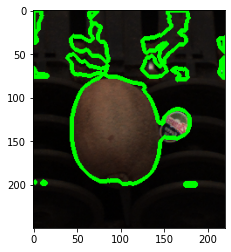

In [26]:
contoured_images = [np.copy(img) for img in colour_imgs]

cv.drawContours(contoured_images[0], contours[0], -1, (0,255,0), 3)

plt.imshow(cv.cvtColor(contoured_images[0], cv.COLOR_BGR2RGB))
plt.show()

In [27]:
max_contours = [sorted(c, key=cv.contourArea)[-1] for c in contours]

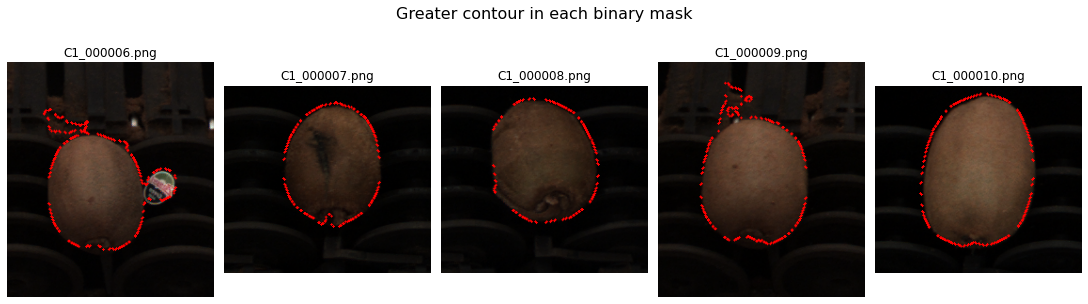

In [28]:
contoured_images = [np.copy(img) for img in colour_imgs]

for img, c in zip(contoured_images, max_contours):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')

In [29]:
def smooth(contour):
    k = 15
    c = cv.copyMakeBorder(contour,  (k-1) // 2, (k-1) // 2 ,0, 0, cv.BORDER_WRAP);
    return cv.blur(c, (1,k),(-1,-1));

cs = [smooth(c) for c in max_contours]

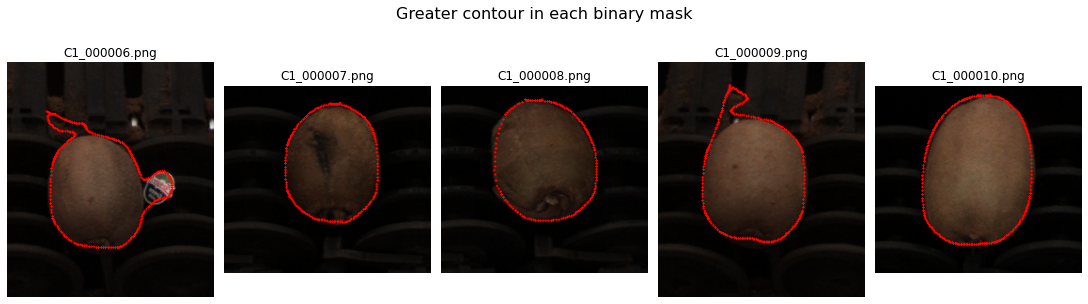

In [30]:
contoured_images = [np.copy(img) for img in colour_imgs]

for img, c in zip(contoured_images, cs):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')

In [31]:
contoured_images = [np.copy(img) for img in colour_imgs]

rect = cv.minAreaRect(contours[0])
box = cv.boxPoints(rect)
box = np.int0(box)
cv.drawContours(contoured_images[0], [box], 0,(0,0,255),2)

plt.imshow(cv.cvtColor(contoured_images[0], cv.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'minAreaRect'
> Overload resolution failed:
>  - points is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'points'


In [ ]:
'''smoothened = [cv.approxPolyDP(s, .5, True) for s in max_contours]'''


In [ ]:
'''contoured_images = [np.copy(img) for img in colour_imgs]

for img, c in zip(contoured_images, smoothened):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')''';

In [ ]:
'''def get_convexity_points(contour):
    #contours, _ = cv2.findContours(component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #contour = contours[0]

    hull = cv2.convexHull(contour, returnPoints=False)

    points = []

    defects = cv2.convexityDefects(contour, hull)

    if defects is None:
        return points

    for i in range(defects.shape[0]):
        _, _, index, _ = defects[i, 0]
        point = tuple(contour[index][0])
        points.append(point)

    return np.array([points])''';

In [ ]:
'''conv_points = [get_convexity_points(c) for c in cs]


contoured_images = [np.copy(img) for img in colour_imgs]
print()
for img, c in zip(contoured_images, conv_points):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')''';

In [ ]:
'''convex_hulls = [cv.convexHull(c, returnPoints=False) for c in max_contours]
defects = [cv.convexityDefects(c, h) for c, h in zip(max_contours, convex_hulls)]''';

In [ ]:
'''for im, h in zip(colour_imgs, convex_hulls):
    # create an empty black image
    drawing = np.copy(im)

    # draw contours and hull points
    cv.drawContours(drawing, h, -1, (0, 255,0), 3)
    plt.imshow(cv.cvtColor(drawing, cv.COLOR_BGR2RGB))
    plt.show()
''';

In [ ]:
print(len(defects))

In [ ]:
print(defects[0][0])

In [ ]:
def ed2(lhs, rhs):
    return(lhs[0] - rhs[0])*(lhs[0] - rhs[0]) + (lhs[1] - rhs[1])*(lhs[1] - rhs[1])


def remove_from_contour(contour, defectsIdx, tmp):
    minDist = sys.maxsize
    startIdx, endIdx = 0, 0

    for i in range(0,len(defectsIdx)):
        for j in range(i+1, len(defectsIdx)):
            dist = ed2(contour[defectsIdx[i]][0], contour[defectsIdx[j]][0])
            if minDist > dist:
                minDist = dist
                startIdx = defectsIdx[i]
                endIdx = defectsIdx[j]

    if startIdx <= endIdx:
        inside = contour[startIdx:endIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:startIdx]
        outside2 = contour[endIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len2 < len1:
            startIdx,endIdx = endIdx,startIdx     
    else:
        inside = contour[endIdx:startIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:endIdx]
        outside2 = contour[startIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len1 < len2:
            startIdx,endIdx = endIdx,startIdx

    if startIdx <= endIdx:
        out = np.concatenate((contour[0:startIdx], contour[endIdx:len(contour)]), axis=0)
    else:
        out = contour[endIdx:startIdx]
    return out


def remove_defects(mask, debug=False):
    tmp = mask.copy()
    #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # get contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    assert len(contours) > 0, "No contours found"
    contour = sorted(contours, key=cv2.contourArea)[-1] #largest contour
    if debug:
        init = cv2.drawContours(tmp.copy(), [contour], 0, (255, 0, 255), 1, cv2.LINE_AA)
        figure, ax = plt.subplots(1)
        ax.imshow(init)
        ax.set_title("Initital Contour")

    hull = cv2.convexHull(contour, returnPoints=False)
    defects = cv2.convexityDefects(contour, hull)

    while True:
        defectsIdx = []
        
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            start = tuple(contour[s][0])
            end = tuple(contour[e][0])
            far = tuple(contour[f][0])
            
            depth = d / 255
            #print(depth)
            if depth > 5:
                defectsIdx.append(f)

        if len(defectsIdx) < 2:
            break

        contour = remove_from_contour(contour, defectsIdx, tmp)
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour, hull)

    if debug:
      rslt = cv2.drawContours(tmp.copy(), [contour], 0, (0, 0, 255), 2)
      figure, ax = plt.subplots(1)
      ax.imshow(rslt)
      ax.set_title("Corrected Contour")

In [ ]:
cv2 = cv

In [ ]:
remove_defects(masks[3], debug=True)